# Train 1D BN Scene Gen Model

In [1]:
using AutomotiveDrivingModels
using AutoViz
using NGSIM

include("../AutoMobius/AutoMobius.jl")
using AutoMobius

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.6/NGSIM.ji for module NGSIM.


In [2]:
scene_length = 200.0 # [m]
scene = MobiusScene()
roadway = Wraparound(Straight1DRoadway(scene_length));

In [3]:
trajdata = load_ngsim_trajdata(1);

  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
in #readtable#84 at /home/tim/.julia/v0.6/DataFrames/src/dataframe/io.jl
  likely near In[3]:1
in #readtable#84 at /home/tim/.julia/v0.6/DataFrames/src/dataframe/io.jl
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
  likely near In[3]:1
in builddf at /home/tim/.julia/v0.6/DataFrames/src/dataframe/io.jl


In [4]:
# vehicle definitions
defs = Dict{Int, BoundingBoxDef}()
for id in NGSIM.carid_set(trajdata)
    frame = NGSIM.get_frame_range(trajdata, id)[1]
    d = NGSIM.car_df_index(trajdata, id, frame)
    class = trajdata.df[d, :class]
    if class == 1
        class = AgentClass.MOTORCYCLE
    elseif class == 2
        class = AgentClass.CAR
    elseif class == 3
        class = AgentClass.TRUCK
    else
        error("unknown class type ", class)
    end
    len = trajdata.df[d, :length] * NGSIM.METERS_PER_FOOT
    wid = trajdata.df[d, :width] * NGSIM.METERS_PER_FOOT
    defs[id] = BoundingBoxDef(class, len, wid)
end

In [5]:
scenes = MobiusScene[]
frameskip = 10
for frame in 500 : frameskip : nframes(trajdata) - 500
    cars = NGSIM.carsinframe(trajdata, frame)
    if !isempty(cars)
        car_df_indices = NGSIM.car_df_index.(trajdata, cars, frame)
        arr_s = convert(Vector{Float64}, trajdata.df[car_df_indices, :local_y]) .*  NGSIM.METERS_PER_FOOT
        arr_lane = convert(Vector{Int}, trajdata.df[car_df_indices, :lane])
        for lane in unique(arr_lane)
            indices_in_lane = find(arr_lane .== lane)
            ids_in_lane = cars[indices_in_lane]
            arr_s_inlane_fore = arr_s[indices_in_lane]
            arr_s_inlane_rear = arr_s_inlane_fore - [defs[id].len for id in ids_in_lane]
            s_lo, s_hi = minimum(arr_s_inlane_rear), maximum(arr_s_inlane_fore)
            for s in s_lo - 10.0 : scene_length : s_hi + 10
                a = s
                b = s + scene_length
                scene = MobiusScene()
                for (s_rear, s_fore, id) in zip(arr_s_inlane_rear, arr_s_inlane_fore, ids_in_lane)
                    if s_rear > a && s_fore < b
                        v = trajdata.df[NGSIM.car_df_index(trajdata, id, frame), :speed] * NGSIM.METERS_PER_FOOT
                        state = PosSpeed1D((s_rear + s_fore)/2 - a, v)
                        def = defs[id]
                        push!(scene, MobiusEntity(state, def, id))
                    end
                end
                if length(scene) > 1 && !has_collision(scene, roadway) # at least 2 cars
                    push!(scenes, scene)
                end
            end
        end
    end
end
length(scenes)

14458

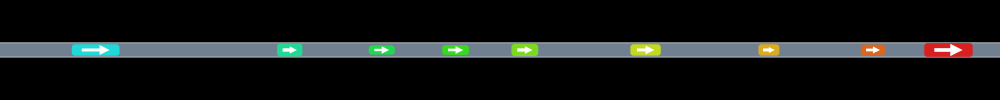

In [6]:
using Interact
i = 100
# @manipulate for i in 1 : length(scenes)
    scene = scenes[i]
    cam = StaticCamera(VecE2(100.0,0.0), 4.75)
    car_colors = get_pastel_car_colors(scene)
    render(scene, roadway, cam=cam, canvas_height=100, car_colors=car_colors)
# end

In [7]:
open("../data/scenes_NGSIM.txt", "w") do io
    write(io, MIME"text/plain"(), scenes)
end